## SPACY LIB for transformers

In [ ]:
!pip install spacy-transformers


In [ ]:
!python -m spacy download en_trf_bertbaseuncased_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_trf_bertbaseuncased_lg')


## Loading the default bert model

In [ ]:
import spacy
import torch
import numpy
from numpy.testing import assert_almost_equal

# is_using_gpu = spacy.prefer_gpu()
# if is_using_gpu:
#     torch.set_default_tensor_type("torch.cuda.FloatTensor")

nlp = spacy.load("en_trf_bertbaseuncased_lg")
doc = nlp("Here is some text to encode.")

## Importing Libraries

In [ ]:
import pandas as pd 
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
# import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

## DATASET Function from Baseline model

In [ ]:
from csv import DictReader
class DataSet():
    def __init__(self, name="train", path="./data"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))



    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows


In [ ]:
# from utils.dataset import DataSet
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM, Dense
from keras.models import Sequential
import re
import csv
import nltk

nltk.download('punkt')
nltk.download('wordnet')



def generate_features(stances,dataset):
    h, b, y = [],[],[]
    LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
    for stance in stances:

        # print(stance['Stance'])
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])
   

    return(h,b,y)

d=DataSet()
h,b,y= generate_features(d.stances,d)

combined_list = [list(x) for x in zip(h, b,y)]



combine_df_train=pd.DataFrame(combined_list,columns = ["Headline","articleBody","Stances"])
combine_df_train.to_csv("./data/combined_list_1.csv")




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Reading dataset
Total stances: 49972
Total bodies: 1683


In [ ]:
competition_dataset = DataSet("competition_test")
h_test,b_test,y_test= generate_features(competition_dataset.stances,competition_dataset)

combined_list_test = [list(x_test) for x_test in zip(h_test, b_test, y_test)]

combine_df_test=pd.DataFrame(combined_list_test,columns = ["Headline","articleBody","Stances"])
combine_df_test.to_csv("./data/combined_list_test.csv")


Reading dataset
Total stances: 25413
Total bodies: 904


## PREPROCESSING

In [ ]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]
word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [ ]:
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])

# word_seq_test_1 = []
for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])

In [ ]:
MAX_SENT_LEN = 150 
MAX_VOCAB_SIZE = 40000 
LSTM_DIM = 100
EMBEDDING_DIM=768 #Embedding Dim for bert
BATCH_SIZE = 128
N_EPOCHS = 50

In [ ]:
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
#because it only includes unique words(tokens)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 35978


In [ ]:
# Combine headline and body together
word_seq_train = [list(i) for i in word_seq_head_train]
for i in range(len(word_seq_head_train)):
    word_seq_train[i].extend(word_seq_bodies_train[i]) 
    
word_seq_test = [list(i) for i in word_seq_head_test]
for i in range(len(word_seq_head_test)):
    word_seq_test[i].extend(word_seq_bodies_test[i])

In [ ]:
# Shorten the sentence to a fixed length and Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = combine_df_train['Stances']


In [ ]:
X_test = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test])
X_test = pad_sequences(X_test, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_test_1 = combine_df_test['Stances']

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test_1)

In [ ]:
# # Encode class values as integers
# encoder_train = LabelEncoder()
# encoder_train.fit(y_train)
# encoded_train = encoder_train.transform(y_train)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y_train = np_utils.to_categorical(encoded_train)


In [ ]:
X_train, y_train,X_vali, y_vali = train_test_split(X_train,y_train,random_state=42)

## EMBEDDING MATRIX From Bert

In [ ]:
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings=nlp(word)
        embeddings_vector = embeddings.vector
    except:
        embeddings_vector = None
        #none: if words in sentence don't have pre-trained corresponding embedding, then error occurs

    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        #if pre-trained word embedding exists，then let embeddings_matrix[i] is this embedding
        #Wi:the ith row of embeddings_matrix
        
# del embeddings

## MODEL

In [ ]:
# Build a sequential model by stacking neural net units 
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', #False
                          mask_zero=True))

model_1.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model_1.add(Dropout(rate=0.8, name='dropout_1')) 
model_1.add(Dense(4, activation='softmax', name='output_layer'))

In [ ]:
filepath="/content/drive/My Drive/MSCI_641_project/best_model_3.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_accuracy', 
                                       verbose=1,mode='max', 
                                       save_best_only=True)

callbacks_list1 = [checkpoint]

In [ ]:
#before trainning model, we need to compile it used adam optimizer
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#%%capture history
#using different emedding pretrained dataset
history_3 = model_1.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=50,
          validation_data=(X_vali, y_vali),callbacks = callbacks_list1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44974 samples, validate on 4998 samples
Epoch 1/50
44974/44974 [==============================] - 243s 5ms/step - loss: 0.8274 - accuracy: 0.7283 - val_loss: 0.7706 - val_accuracy: 0.7291

Epoch 00001: val_accuracy improved from -inf to 0.72909, saving model to /content/drive/My Drive/MSCI_641_project/best_model_3.hdf5
Epoch 2/50
44974/44974 [==============================] - 240s 5ms/step - loss: 0.7774 - accuracy: 0.7314 - val_loss: 0.7369 - val_accuracy: 0.7291

Epoch 00002: val_accuracy did not improve from 0.72909
Epoch 3/50
44974/44974 [==============================] - 239s 5ms/step - loss: 0.7309 - accuracy: 0.7322 - val_loss: 0.6916 - val_accuracy: 0.7301

Epoch 00003: val_accuracy improved from 0.72909 to 0.73009, saving model to /content/drive/My Drive/MSCI_641_project/best_model_3.hdf5
Epoch 4/50
44974/44974 [==============================] - 238s 5ms/step - loss: 0.6718 - accuracy: 0.7405 - val_loss: 0.6430 - val_accuracy: 0.7395

Epoch 00004: val_accuracy improve

In [ ]:
import pickle


with open('/content/drive/My Drive/MSCI_641_project/history.pickle', 'wb') as handle:
    pickle.dump(history_3, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('BIDIRECTIONAL LSTM + BERT EMBEDDINGS LOSS')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plotAccuracy(history):  
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('BIDIRECTIONAL LSTM + BERT EMBEDDINGS ACCURACY')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

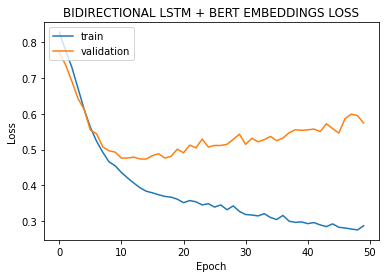

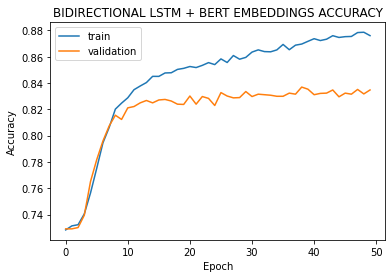

In [ ]:
plotLosses(history_3)
plotAccuracy(history_3)

In [ ]:
history_3 = model_1.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          initial_epoch=40,
          epochs=100,
          validation_data=(X_vali, y_vali),callbacks = callbacks_list1)

Train on 44974 samples, validate on 4998 samples
Epoch 41/100
44974/44974 [==============================] - 379s 8ms/step - loss: 0.2417 - accuracy: 0.8993 - val_loss: 0.4898 - val_accuracy: 0.8557

Epoch 00041: val_accuracy improved from 0.85394 to 0.85574, saving model to best_model.hdf5
Epoch 42/100
44974/44974 [==============================] - 379s 8ms/step - loss: 0.2425 - accuracy: 0.8966 - val_loss: 0.4960 - val_accuracy: 0.8543

Epoch 00042: val_accuracy did not improve from 0.85574
Epoch 43/100
44974/44974 [==============================] - 382s 8ms/step - loss: 0.2316 - accuracy: 0.9016 - val_loss: 0.4889 - val_accuracy: 0.8463

Epoch 00043: val_accuracy did not improve from 0.85574
Epoch 44/100
44974/44974 [==============================] - 386s 9ms/step - loss: 0.2343 - accuracy: 0.9024 - val_loss: 0.6431 - val_accuracy: 0.8349

Epoch 00044: val_accuracy did not improve from 0.85574
Epoch 45/100
44974/44974 [==============================] - 380s 8ms/step - loss: 0.2364 -